In [1]:
import torch
import wandb
from tqdm.auto import tqdm
from torchmetrics import AUROC, ROC, Accuracy
from dataset import ImageDatasetFromParquet
import torch_geometric
import torchvision.transforms as T
import torchvision
import copy
import matplotlib.pyplot as plt

/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

import random
random.seed(42)

import numpy as np
np.random.seed(42)

In [3]:
DEVICE = "cuda"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
NUM_EPOCHS = 5

In [4]:
required_transform = [
    #T.Resize(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    # T.RandomAdjustSharpness(0.5, p=0.1),
]

In [5]:
run_0_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet"
run_1_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet"
run_2_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"


run_0_ds = ImageDatasetFromParquet(run_0_path, transforms=required_transform)
run_1_ds = ImageDatasetFromParquet(run_1_path, transforms=required_transform)
run_2_ds = ImageDatasetFromParquet(run_2_path, transforms=required_transform)

combined_dset = torch.utils.data.ConcatDataset([run_0_ds, run_1_ds, run_2_ds])

In [6]:
TEST_SIZE = 0.2
VAL_SIZE = 0.15

test_size = int(len(combined_dset) * TEST_SIZE)
val_size = int(len(combined_dset) * VAL_SIZE)
train_size = len(combined_dset) - val_size - test_size

train_dset, val_dset, test_dset = torch.utils.data.random_split(
    combined_dset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42),
)

In [7]:
test_dset.required_transforms = [T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

In [8]:
train_loader = torch.utils.data.DataLoader(train_dset, shuffle=True, batch_size=TRAIN_BATCH_SIZE, pin_memory=True, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_dset, shuffle=False, batch_size=VAL_BATCH_SIZE, pin_memory=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dset, shuffle=False, batch_size=TEST_BATCH_SIZE, num_workers=16)

The approach only uses data from the energy deposits, as it was not clear whether $p_T$ and $m_0$ was allowed to be used for classification

In [9]:
def get_model(device):
    model = torchvision.models.resnet50(pretrained=True)

    in_features = model.fc.in_features

    model.fc = torch.nn.Linear(in_features, 1, bias=True)

    model = model.to(device)
    return model

In [10]:
def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
def train(num_epochs, model, criterion, optimizer, train_loader, val_loader, device):
    best_model = copy.deepcopy(model).to('cpu', non_blocking=True)
    best_val_auroc = 0
    train_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    val_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    acc = Accuracy().to(device, non_blocking=True)
    
    for epoch in range(num_epochs):
        model.train()
        tqdm_iter = tqdm(train_loader, total=len(train_loader))
        tqdm_iter.set_description(f"Epoch {epoch}")

        for it, batch in enumerate(tqdm_iter):
            optimizer.zero_grad()

            X, y = batch['X_jets'].float(), batch['y']

            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            out = model(X)

            loss = criterion(out, y.unsqueeze(-1))

            pred = torch.sigmoid(out.detach()).squeeze()
            acc.update(pred, y.detach().long())
            train_auroc.update(pred, y.detach().long())

            tqdm_iter.set_postfix(loss=loss.item(), acc=acc.compute().item())
            wandb.log({
                "train_loss": loss.item(),
                "train_acc": acc.compute().item(),
                "train_step": (it * TRAIN_BATCH_SIZE) + epoch * train_size
            })

            loss.backward()
            optimizer.step()

        wandb.log({
            "train_auroc": train_auroc.compute(),
            "train_epoch": epoch
        })
        train_auroc.reset()
        acc.reset()

        model.eval()
        val_tqdm_iter = tqdm(val_loader, total=len(val_loader))
        val_tqdm_iter.set_description(f"Validation Epoch {epoch}")

        for it, batch in enumerate(val_tqdm_iter):
            with torch.no_grad():
                X, y = batch['X_jets'].float(), batch['y']

                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

                out = model(X)

                loss = criterion(out, y.unsqueeze(-1))

                pred = torch.sigmoid(out.detach()).squeeze() 
                acc.update(pred, y.detach().to(torch.long, non_blocking=True))
                val_auroc.update(pred, y.to(torch.long, non_blocking=True))

                val_tqdm_iter.set_postfix(loss=loss.item(), acc=acc.compute().item())
                wandb.log({
                    "val_loss": loss.item(),
                    "val_acc": acc.compute().item(),
                    "val_step": (it * VAL_BATCH_SIZE) + epoch * val_size
                })

        val_auroc_val = val_auroc.compute()
        wandb.log({
            "val_auroc": val_auroc_val,
            "val_epoch": epoch
        })
        
        if val_auroc_val > best_val_auroc:
            best_model = copy.deepcopy(model).to('cpu', non_blocking=True)
            best_val_auroc = val_auroc_val
        
        val_auroc.reset()
        acc.reset()
        
    del model

    return best_model.to(device, non_blocking=True)

In [12]:
def test(model, test_loader, device):
    model.eval()
    test_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    test_acc = Accuracy().to(device, non_blocking=True)
    test_roc_non_wandb = ROC(num_classes=None).to(device, non_blocking=True)
    tqdm_iter = tqdm(test_loader, total=len(test_loader))
    
    pred_list = []
    ground_truth_list = []
    
    
    for it, batch in enumerate(tqdm_iter):
        with torch.no_grad():
            X, y = batch['X_jets'].float(), batch['y']

            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            out = model(X)

            pred = torch.sigmoid(out.detach()).squeeze() 
            test_acc.update(pred, y.long())
            test_auroc.update(pred, y.long())
            test_roc_non_wandb.update(pred, y.long())
            
            pred_list.append(
                pred.cpu()
            )
            ground_truth_list.append(
                y.cpu().long()
            )
            
            tqdm_iter.set_postfix(acc=test_acc.compute().item())
            
    pred_list = torch.cat(pred_list)
    output = torch.cat([1 - pred_list.unsqueeze(-1), pred_list.unsqueeze(-1)], dim=1)
    ground_truth_list = torch.cat(ground_truth_list)
    
    wandb.log({"test_pr_curve": wandb.plot.pr_curve(ground_truth_list, output), 
               "test_roc_curve": wandb.plot.roc_curve(ground_truth_list, output)})
            
    return test_acc.compute().item(), test_auroc.compute().item(), test_roc_non_wandb.cpu().compute()

In [13]:
def main(run_name):
    wandb.init(name=run_name, project='gsoc-submission')
    
    model = get_model(DEVICE)
    
    opt = get_optimizer(model, lr=3e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    model = train(NUM_EPOCHS, model, criterion, opt, train_loader, val_loader, DEVICE)
    test_acc, test_auroc, test_roc = test(model, test_loader, DEVICE)
    print(f"Model on Test dataset: Accuracy: {test_acc} \t AUROC: {test_auroc}")
    
    fpr, tpr, threshold = test_roc
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()
    
    print(f"Thresholds: {threshold.numpy()}")
    
    wandb.finish()
    
    return model

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jai-bardhan (use `wandb login --relogin` to force relogin)


/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Validation Epoch 4: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s, acc=0.723, loss=0.685]
/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 436/436 [02:06<00:00,  3.45it/s, acc=0.723]
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


Model on Test dataset: Accuracy: 0.7232332229614258 	 AUROC: 0.7933233976364136


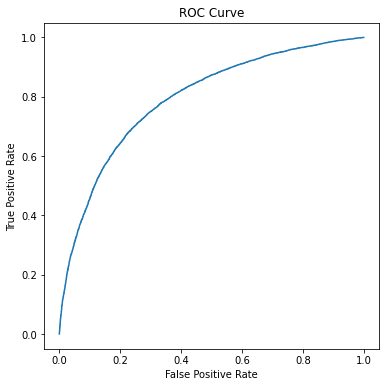

Thresholds: [1.9865048  0.98650485 0.9835271  ... 0.0538651  0.0534877  0.0497588 ]



train_acc,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇▇
train_auroc,▁▆▆██
train_epoch,▁▃▅▆█
train_loss,▆▅▄▆▄█▆▄▆▄▃▅▅▄▃▂▅▂█▇▃█▄▄▆▅▄▁▃▁▄▅▃▆▄▄▁▇▄▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,█▇██▇▇▇▇▁▂▄▃▃▃▃▃▆▅▆▇▆▆▆▆▅▆▆▆▆▆▆▆▇▆▆▇▆▇▇▆
val_auroc,▅▁▅▆█
val_epoch,▁▃▅▆█
val_loss,▃▄▅▄▂▆▁▄▆▅▅▅▆▅▅▅▄▄▄█▂▅▆▅▅▂▁▃▃▆▄▅▁▁▆▂▂▃▄▂
val_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,0.72201


In [14]:
model = main('task_2_class_resnet')

In [15]:
torch.save(model.state_dict(), "task_2_class_model.pt")